<a href="https://colab.research.google.com/github/MatSci495/Lectures/blob/main/arpls_baseline_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# arPLS Baseline Correction — Compact Demo (N=10)

Reference:
https://pubs.rsc.org/en/content/articlepdf/2015/an/c4an01061b


This notebook demonstrates **asymmetrically reweighted, penalized least-squares (arPLS)** baseline correction on a tiny synthetic Raman-like spectrum (N=10 points). It is designed for teaching:
- Start with **uniform weights** to show standard smoothing.
- Then iterate **arPLS** with a **logistic weight update** based on the **negative residuals** (noise-dominated) to downweight positive residuals (peaks).
- Visual diagnostics: **weight evolution**, **weights vs. residuals**, and a **residual histogram**.

**How to use:**
1. Run cells in order (Runtime → Run all).  
2. Tweak the parameters in the next cell (e.g., `LAMBDA`, `K_SIGMA`).  
3. Re-run to see how the corrected spectrum changes.

> No seaborn; each chart is a separate figure; no explicit color choices (Colab defaults).


In [ ]:

# --- Parameters (edit these) ---
N = 10           # number of samples (keep small for "almost by hand" teaching)
LAMBDA = 1e5     # smoothing strength; larger = stiffer baseline (paper suggests ~1e5)
K_SIGMA = 2.0    # logistic threshold: center at mu + K_SIGMA * sigma
MAX_ITER = 10    # number of arPLS reweighting iterations
TOL = 1e-7       # convergence tolerance on mean |Δw|

SEED = 7         # RNG seed for reproducibility


# The Model Raman Spectrum

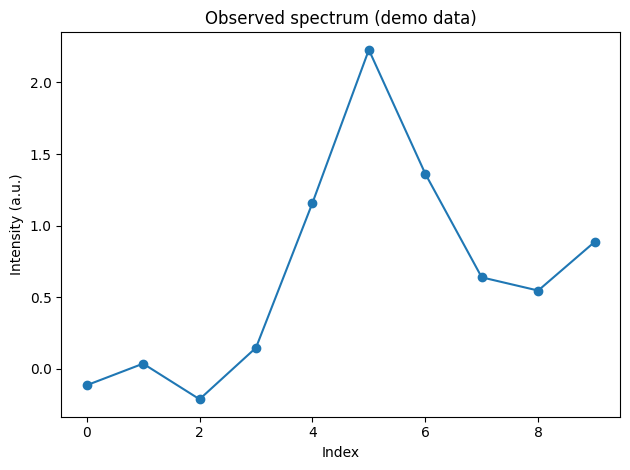

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

SEED = 10
np.random.seed(SEED)

# --- Synthetic data (N points) ---
x = np.arange(N)

# Linear baseline + narrow peak + extra wing noise
baseline_true = 0.12 * x - 0.3
peak = 2.0 * np.exp(-0.5 * ((x - 5.0) / 0.8) ** 2)

noise = np.random.normal(0, 0.1, N)
noise[:2]  += np.random.normal(0, 0.12, 2)  # left wing extra noise
noise[-2:] += np.random.normal(0, 0.12, 2)  # right wing extra noise

y = baseline_true + peak + noise

# Quick look at the raw spectrum
plt.figure()
plt.plot(x, y, marker='o')
plt.xlabel('Index')
plt.ylabel('Intensity (a.u.)')
plt.title('Observed spectrum (demo data)')
plt.tight_layout()
plt.show()


## Model for the Simulated Spectrum

The simulated "observed" Raman spectrum $y(x)$ is constructed as a sum of a linear baseline, a Gaussian peak, and random noise:

$$y(x) = \text{baseline}(x) + \text{peak}(x) + \text{noise}(x)$$

where:

*   **Baseline:** A linear function of the index $x$:

    $$\text{baseline}(x) = mx + c$$

    In this simulation, $m = 0.12$ and $c = -0.3$.

*   **Peak:** A Gaussian function centered at $x_0$ with amplitude $A$ and width $\sigma_p$:

    $$\text{peak}(x) = A \exp\left(-\frac{(x - x_0)^2}{2\sigma_p^2}\right)$$

    In this simulation, $A = 2.0$, $x_0 = 5.0$, and $\sigma_p = 0.8$.

*   **Noise:** Random values drawn from a normal distribution with mean 0 and standard deviation $\sigma_n$. Additional noise is added to the wings.

    $$\text{noise}(x) \sim \mathcal{N}(0, \sigma_n^2)$$

    In this simulation, the base noise has $\sigma_n = 0.1$. Extra noise with $\sigma_n = 0.12$ is added to the first two and last two data points.

## Solving for the Baseline

The baseline $z$ is determined by solving a system of linear equations derived from minimizing a cost function that balances fidelity to the observed data $y$ and smoothness of the baseline.

The cost function is:

$$ \mathcal{L}(z) = \sum_{i=1}^N w_i (y_i - z_i)^2 + \lambda \sum_{i=1}^{N-2} (z_i - 2z_{i+1} + z_{i+2})^2 $$

where:
*   $w_i$ are weights for each data point.
*   $\lambda$ is the smoothing parameter.
*   The second term is the sum of the squared second differences of the baseline $z$, which penalizes roughness.

Minimizing this cost function with respect to $z$ leads to the following system of linear equations:

$$ (\mathbf{W} + \lambda \mathbf{D}^T \mathbf{D}) \mathbf{z} = \mathbf{W} \mathbf{y} $$

where:
*   $\mathbf{W}$ is a diagonal matrix with the weights $w_i$ on the diagonal.
*   $\mathbf{D}$ is the second-difference matrix. For $N=10$, the explicit form of $\mathbf{D}$ is a $(10-2) \times 10$ matrix:

<br>

$$
\mathbf{D} = \begin{pmatrix}
1 & -2 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & -2 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & -2 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & -2 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & -2 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & -2 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & -2 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & -2 & 1
\end{pmatrix}
$$

<br>

The `solve_baseline` function computes the matrix $(\mathbf{W} + \lambda \mathbf{D}^T \mathbf{D})$ and solves the linear system for $\mathbf{z}$.

In [ ]:

# Helpers: second-difference matrix and weighted solve
def second_diff_matrix(N: int):
    # (N-2) x N second-difference matrix with [1, -2, 1] stencil
    D = np.zeros((N - 2, N))
    for i in range(N - 2):
        D[i, i]     = 1.0
        D[i, i + 1] = -2.0
        D[i, i + 2] = 1.0
    return D

def solve_baseline(y, lam=1e5, w=None):
    # Solve (W + lam * D^T D) z = W y for baseline z. Returns z and A.
    y = np.asarray(y, float)
    N = y.size
    D = second_diff_matrix(N)
    H = D.T @ D
    W = np.diag(w if w is not None else np.ones(N))
    A = W + lam * H
    z = np.linalg.solve(A, W @ y)
    return z, A


## ITERATION OF LOGISTIC WEIGHTS

In [ ]:

# arPLS logistic weights and iteration loop
def arpls_logistic_weights(residuals, k_sigma=2.0):
    # Estimate mu and sigma from NEGATIVE residuals; fallback to all residuals if needed.
    r = np.asarray(residuals, float)
    neg = r[r < 0.0]
    if neg.size >= 2:
        mu = neg.mean()
        sigma = neg.std(ddof=1)
        if sigma <= 1e-12:
            sigma = max(r.std(ddof=1), 1e-12)
    else:
        mu = r.mean()
        sigma = max(r.std(ddof=1), 1e-12)

    t = (r - (mu + k_sigma * sigma)) / max(sigma, 1e-12)
    # Large positive t -> weight ~ 0 (downweight peaks). Overflow just saturates to 0.
    w = 1.0 / (1.0 + np.exp(t))
    return w, (mu, sigma)

def run_arpls(y, lam=1e5, k_sigma=2.0, max_iter=15, tol=1e-8, w0=None):
    # Returns final baseline z, corrected s, and a history dict.
    N = len(y)
    if w0 is None:
        w = np.ones(N)
    else:
        w = np.asarray(w0, float)

    z_list, s_list, w_list, stats_list = [], [], [], []
    for it in range(max_iter):
        z, _ = solve_baseline(y, lam=lam, w=w)
        s = y - z
        z_list.append(z.copy())
        s_list.append(s.copy())
        w_old = w.copy()
        w, stats = arpls_logistic_weights(s, k_sigma=k_sigma)
        w_list.append(w.copy())
        stats_list.append(stats)
        if np.mean(np.abs(w - w_old)) < tol:
            break

    history = {"z_list": z_list, "s_list": s_list, "w_list": w_list, "stats_list": stats_list}
    return z_list[-1], s_list[-1], history


## Explanation of Algorithm

The core of the arPLS algorithm lies in iteratively refining the baseline estimate by adjusting weights assigned to each data point. Points that are likely part of a peak (positive residuals after subtracting the estimated baseline) are downweighted, while those likely part of the baseline (negative or near-zero residuals) retain higher weights.

The process is implemented in the `run_arpls` function and uses the `arpls_logistic_weights` helper function:

1.  **Initialization:** The algorithm starts with uniform weights for all data points (usually $w_i = 1$).

2.  **Baseline Estimation:** Using the current weights, a baseline $z$ is estimated by solving the linear system described previously:

    $$ (\mathbf{W} + \lambda \mathbf{D}^T \mathbf{D}) \mathbf{z} = \mathbf{W} \mathbf{y} $$

    where $\mathbf{W}$ is a diagonal matrix of the current weights.

3.  **Residual Calculation:** The residuals $r = y - z$ are calculated. These represent the difference between the observed spectrum and the estimated baseline.

4.  **Weight Update:** The `arpls_logistic_weights` function updates the weights based on the residuals. It focuses on the distribution of *negative* residuals, which are assumed to represent noise around the true baseline.
    *   It estimates the mean ($\mu$) and standard deviation ($\sigma$) of the negative residuals.
    *   It calculates a threshold based on these statistics and the `k_sigma` parameter: $\mu + k_{\sigma} \sigma$.
    *   It then calculates a value $t$ for each residual:
        $$ t = \frac{r - (\mu + k_{\sigma} \sigma)}{\max(\sigma, 10^{-12})} $$
    *   Finally, it uses a logistic function to determine the new weight $w_i$ for each point:
        $$ w_i = \frac{1}{1 + e^{t_i}} $$
        This function assigns weights close to 1 for points with small or negative residuals (likely baseline) and weights close to 0 for points with large positive residuals (likely peaks). The $\max(\sigma, 10^{-12})$ in the denominator prevents division by zero if the standard deviation is very small.

5.  **Iteration:** Steps 2-4 are repeated for a fixed number of iterations (`max_iter`) or until the change in weights falls below a specified tolerance (`tol`).

6.  **Output:** The function returns the final estimated baseline ($z$), the final corrected spectrum ($y-z$), and a history of the intermediate results (baselines, residuals, weights, and statistics) from each iteration.

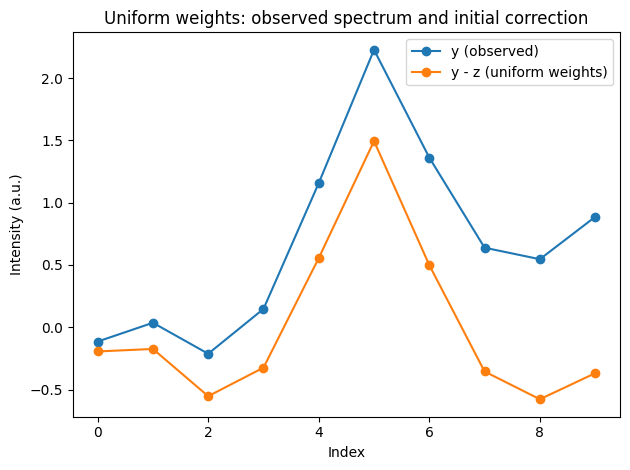

In [ ]:

# Uniform-weights correction (for comparison)
z_uniform, _ = solve_baseline(y, lam=LAMBDA, w=np.ones(N))
s_uniform = y - z_uniform

plt.figure()
plt.plot(x, y, marker='o', label='y (observed)')
plt.plot(x, s_uniform, marker='o', label='y - z (uniform weights)')
plt.xlabel('Index')
plt.ylabel('Intensity (a.u.)')
plt.title('Uniform weights: observed spectrum and initial correction')
plt.legend()
plt.tight_layout()
plt.show()


N = 10, lambda = 1.0e+05, K_sigma = 2.0, iterations = 10
Final mu (neg. residuals) ~ 0.5639, sigma ~ 0.6559
Final weights: [0.911 0.908 0.946 0.924 0.761 0.43  0.774 0.926 0.946 0.927]


/tmp/ipython-input-4099597686.py:17: RuntimeWarning: overflow encountered in exp
  w = 1.0 / (1.0 + np.exp(t))


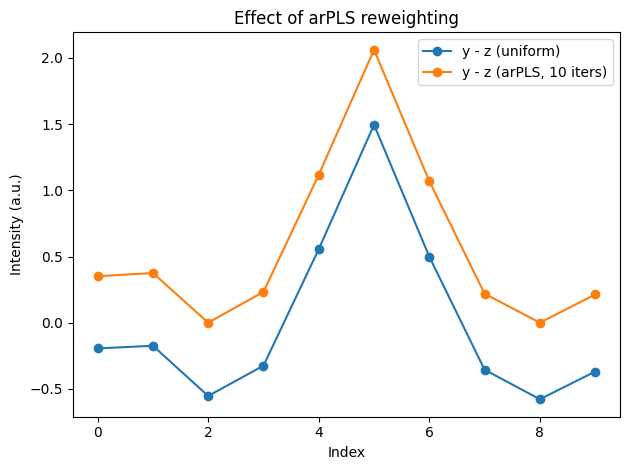

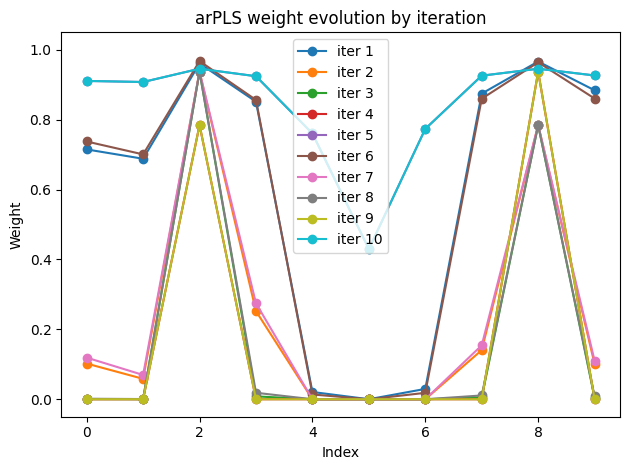

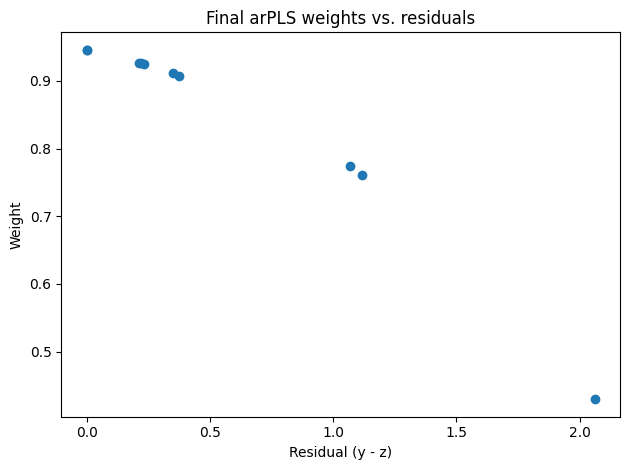

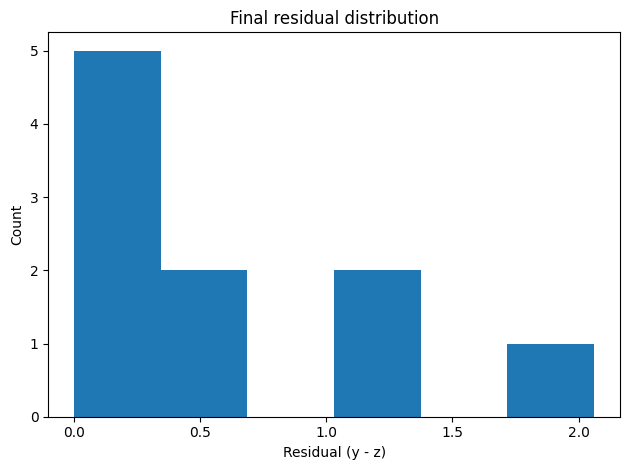

In [ ]:

# arPLS iteration and diagnostics
z_final, s_final, hist = run_arpls(
    y, lam=LAMBDA, k_sigma=K_SIGMA, max_iter=MAX_ITER, tol=TOL, w0=np.ones(N)
)

iters = len(hist["s_list"])
mus = [mu for (mu, _sigma) in hist["stats_list"]]
sigmas = [sigma for (_mu, sigma) in hist["stats_list"]]

print(f"N = {N}, lambda = {LAMBDA:.1e}, K_sigma = {K_SIGMA}, iterations = {iters}")
if iters > 0:
    print(f"Final mu (neg. residuals) ~ {mus[-1]:.4f}, sigma ~ {sigmas[-1]:.4f}")
print("Final weights:", np.round(hist["w_list"][-1], 3))

# Compare uniform vs final arPLS corrected spectra
plt.figure()
plt.plot(x, s_uniform, marker='o', label='y - z (uniform)')
plt.plot(x, s_final, marker='o', label=f'y - z (arPLS, {iters} iters)')
plt.xlabel('Index')
plt.ylabel('Intensity (a.u.)')
plt.title('Effect of arPLS reweighting')
plt.legend()
plt.tight_layout()
plt.show()

# Diagnostic: weight evolution
plt.figure()
for i, w in enumerate(hist["w_list"], start=1):
    plt.plot(x, w, marker='o', label=f'iter {i}')
plt.ylim(-0.05, 1.05)
plt.xlabel('Index')
plt.ylabel('Weight')
plt.title('arPLS weight evolution by iteration')
plt.legend()
plt.tight_layout()
plt.show()

# Diagnostic: weights vs residuals (final)
plt.figure()
plt.scatter(hist["s_list"][-1], hist["w_list"][-1])
plt.xlabel('Residual (y - z)')
plt.ylabel('Weight')
plt.title('Final arPLS weights vs. residuals')
plt.tight_layout()
plt.show()

# Diagnostic: residual histogram (final)
plt.figure()
plt.hist(hist["s_list"][-1], bins=max(6, N//2))
plt.xlabel('Residual (y - z)')
plt.ylabel('Count')
plt.title('Final residual distribution')
plt.tight_layout()
plt.show()


## General description of baseline estimation by (weighted) regularized least squares

**Setup.** Treat the measured spectrum as a vector $\,\mathbf{y}\in\mathbb{R}^N\,$ (baseline + peaks + noise). The goal is to estimate a **smooth baseline** $\,\mathbf{z}\in\mathbb{R}^N\,$ so that the **corrected spectrum** is $\,\mathbf{s}=\mathbf{y}-\mathbf{z}\,$ for subsequent peak fitting.

**Smoothness via second differences.** Let $D$ be the discrete **second-difference** operator using the stencil $[\,1,\,-2,\,1\,]$. It has $(N-2)$ rows and maps $\mathbf{z}$ to local curvatures. Define $H := D^\top D$; then $H$ is symmetric, positive semidefinite, and **banded pentadiagonal** (five nonzeros per row).

### 1) Unweighted Tikhonov formulation

We balance fidelity to the data with a curvature penalty:

$$
S(\mathbf{z}) \;=\; \|\mathbf{y}-\mathbf{z}\|_2^2 \;+\; \lambda\,\|D\mathbf{z}\|_2^2
\;=\; (\mathbf{y}-\mathbf{z})^\top(\mathbf{y}-\mathbf{z}) \;+\; \lambda\,\mathbf{z}^\top H\,\mathbf{z},
\quad \lambda>0.
$$

Minimizing $S$ encourages $\mathbf{z}$ to stay close to $\mathbf{y}$ where the data are flat, but to remain smooth (low curvature) overall.

**Normal equations (unweighted).** Differentiate and set to zero:

$$
\frac{\partial S}{\partial \mathbf{z}}
= -2(\mathbf{y}-\mathbf{z}) + 2\lambda H\mathbf{z} = \mathbf{0}
\;\;\Longrightarrow\;\;
(I + \lambda H)\,\mathbf{z} = \mathbf{y}.
$$

### 2) Add **weights** to down-weight peaks (or mask them)

Introduce per-point weights $\,\mathbf{w}\,$ and $\,W=\mathrm{diag}(\mathbf{w})\,$ to reduce the influence of peaks on the baseline fit (set small weights on suspected peaks; large weights on background):

$$
S(\mathbf{z}) \;=\; (\mathbf{y}-\mathbf{z})^\top W (\mathbf{y}-\mathbf{z})
\;+\; \lambda\,\mathbf{z}^\top H\,\mathbf{z}.
$$

The weighted normal equations become

$$
\frac{\partial S}{\partial \mathbf{z}} =
-2W(\mathbf{y}-\mathbf{z}) + 2\lambda H\mathbf{z} = \mathbf{0}
\;\;\Longrightarrow\;\;
\big(W + \lambda H\big)\,\mathbf{z} = W\,\mathbf{y}.
$$

Thus the **baseline** is obtained by solving the SPD linear system

$$
\mathbf{z} \;=\; \big(W + \lambda D^\top D\big)^{-1} W\,\mathbf{y}.
$$

> **Why this solves fast:**  
> - $W$ is diagonal (positive or semidefinite if some weights are zero).  
> - $H=D^\top D$ is banded and symmetric.  
> Therefore $A:=W+\lambda H$ is **symmetric positive definite** (unless all weights are zero), and can be solved efficiently with banded Cholesky.

### 3) Corrected spectrum

Once $\mathbf{z}$ is found, subtract it to obtain the baseline-free signal for peak fitting:

$$
\mathbf{s} \;=\; \mathbf{y} - \mathbf{z}.
$$

**Algorithmic note.** Methods like **AsLS**, **airPLS**, and **arPLS** differ mainly in **how the weights are updated** from residuals $\mathbf{r}=\mathbf{y}-\mathbf{z}$ between iterations (e.g., logistic or asymmetric rules that down-weight positive residuals/peaks).

